In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

from PIL import Image
from tqdm import tqdm
import numpy as np
import torch
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from models import Showo
from training.prompting_utils import UniversalPrompting, create_attention_mask_predict_next
from training.utils import get_config
import json
import argparse
from PIL import Image
import numpy as np
from omegaconf import OmegaConf
from models.clip_encoder import CLIPVisionTower
from transformers import CLIPImageProcessor
from llava.llava import conversation as conversation_lib
from omegaconf import OmegaConf
from copy import deepcopy
from collections import defaultdict


conversation_lib.default_conversation = conversation_lib.conv_templates["phi1.5"]

/home/vasilevpa/Show-o/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-10-06 08:26:03,247] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.2
 [WARNING]  using untested triton version (2.2.0), only 1.0.0 is known to be compatible


In [2]:
from inference_mmu import run_mmu
from inference_t2i import run_t2i

In [3]:
config = OmegaConf.load('configs/showo_demo_w_clip_vit_512x512.yaml')

In [4]:
def get_model(config):
    model = Showo.from_pretrained(config.model.showo.pretrained_model_path)
    return model

In [5]:
class LayerOutputRecorder:
    def __init__(self):
        self.outputs = defaultdict(list)
        self.handles = []

    def build_hook_fn(self, name):
        def hook_fn(module, input, output):
            self.outputs[name].append(output.detach().cpu())
        return hook_fn

    def register_hook(self, module_name, module):
        handle = module.register_forward_hook(self.build_hook_fn(module_name))
        self.handles.append(handle)

    def register_hooks(self, modules: list[tuple[str, torch.nn.Module]]) -> None:
        for module_name, module in modules:
            self.register_hook(module_name, module)

    def remove_hooks(self):
        for handle in self.handles:
            handle.remove()
        self.handles = []


In [6]:
def get_target_layers(model) -> list[tuple[str, torch.nn.Module]]:
    layers = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            layers.append((name, module))
    return layers

In [7]:
model_t2i = get_model(config)
model_mmu = get_model(config)

The config attributes {'mask_token_id': 58497} were passed to Showo, but are not expected and will be ignored. Please verify your config.json configuration file.
/home/vasilevpa/Show-o/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


attention implementation:  sdpa


/home/vasilevpa/Show-o/models/modeling_showo.py:49: FutureWarning: Accessing config attribute `w_clip_vit` directly via 'Showo' object attribute is deprecated. Please access 'w_clip_vit' over 'Showo's config object instead, e.g. 'unet.config.w_clip_vit'.
  if self.w_clip_vit:
The config attributes {'mask_token_id': 58497} were passed to Showo, but are not expected and will be ignored. Please verify your config.json configuration file.


attention implementation:  sdpa


In [8]:
list(model_mmu.named_modules())

[('',
  Showo(
    (showo): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(58498, 2048)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-23): 24 x PhiDecoderLayer(
            (self_attn): PhiSdpaAttention(
              (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
              (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
              (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
              (dense): Linear(in_features=2048, out_features=2048, bias=True)
              (q_layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
              (k_layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
              (rotary_emb): PhiRotaryEmbedding()
            )
            (mlp): PhiMLP(
              (activation_fn): NewGELUActivation()
              (fc1): Linear(in_features=2048, out_features=8192, bias=True)
              (fc2):

In [9]:
target_layers_t2i = get_target_layers(model_t2i)
activations_recorder_t2i = LayerOutputRecorder()
activations_recorder_t2i.register_hooks(target_layers_t2i)

In [10]:
target_layers_mmu = get_target_layers(model_mmu)
activations_recorder_mmu = LayerOutputRecorder()
activations_recorder_mmu.register_hooks(target_layers_mmu)

In [11]:
# mode=t2i dataset.params.validation_prompts_file=validation_prompts/showoprompts.txt batch_size=1

In [12]:
# uv run inference_t2i.py config=configs/showo_demo_w_clip_vit_512x512.yaml mode=t2i dataset.params.validation_prompts_file=validation_prompts/showoprompts.txt batch_size=1

In [13]:
# uv run inference_mmu.py config=configs/showo_demo_w_clip_vit_512x512.yaml max_new_tokens=100 mmu_image_root=./mmu_validation

In [14]:
cfg = OmegaConf.load("configs/showo_demo_w_clip_vit_512x512.yaml")
cfg.batch_size = 1
cfg.max_new_tokens = 100

cfg_mmu = deepcopy(cfg)
cfg_t2i = deepcopy(cfg)


cfg_t2i.dataset.params.validation_prompts_file="validation_prompts/text2image_prompts.txt"
cfg_t2i.mode = "t2i"
cfg_mmu.mmu_image_root = "./mmu_validation"
cfg_mmu.device = "cuda:5"
cfg_t2i.device = "cuda:4"

In [15]:
run_mmu(cfg_mmu, model_mmu)

Working with z of shape (1, 13, 16, 16) = 3328 dimensions.
Look-up free quantizer with codebook size: 8192


  0%|          | 0/6 [00:00<?, ?it/s]/home/vasilevpa/Show-o/inference_mmu.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids).to(device).squeeze(0)
 17%|█▋        | 1/6 [01:05<05:29, 65.88s/it]

 Yes, it is interacting with something or someone in the image. A dog is standing in a field of flowers, sniffing a flower, and appears to be smelling it. This suggests that the dog is curious and interested in the flower, possibly exploring its surroundings or smelling it as a part of its natural behavior.


 33%|███▎      | 2/6 [02:50<05:55, 88.76s/it]

 The scene appears to be surreal, as it is not a typical representation of a living room or a beach setting. Instead, it features a couch, a table, and a potted plant, all placed on a beach-like surface. The couch is positioned in the middle of the scene, and the table is located to the left of the couch. The potted plant is situated to the right of the couch. The combination of these elements creates an unusual and dreamlike atmosphere, as it is


 50%|█████     | 3/6 [03:07<02:47, 55.87s/it]

 The cat is walking through the snow, moving across the snow-covered ground.


 67%|██████▋   | 4/6 [03:20<01:17, 38.87s/it]

 The time of day in the picture is during the day.


 83%|████████▎ | 5/6 [03:35<00:30, 30.52s/it]

 The character, Spongebob, appears to be expressing happiness or excitement.


100%|██████████| 6/6 [03:55<00:00, 39.28s/it]

 The path or structure is on a set of train tracks that are surrounded by trees and rocks.
=== Multimodal Understanding Results ===

Image 1: dog.txt
Response: User: Is it interacting with something or someone?
 Answer :  Yes, it is interacting with something or someone in the image. A dog is standing in a field of flowers, sniffing a flower, and appears to be smelling it. This suggests that the dog is curious and interested in the flower, possibly exploring its surroundings or smelling it as a part of its natural behavior.

--------------------------------------------------

Image 2: landscape.png
Response: User: Does the scene look realistic or surreal?
 Answer :  The scene appears to be surreal, as it is not a typical representation of a living room or a beach setting. Instead, it features a couch, a table, and a potted plant, all placed on a beach-like surface. The couch is positioned in the middle of the scene, and the table is located to the left of the couch. The potted plant is

In [19]:
activations_recorder_mmu.outputs.keys()

dict_keys(['mm_projector.0', 'mm_projector.2', 'showo.model.layers.0.self_attn.q_proj', 'showo.model.layers.0.self_attn.k_proj', 'showo.model.layers.0.self_attn.v_proj', 'showo.model.layers.0.self_attn.dense', 'showo.model.layers.0.mlp.fc1', 'showo.model.layers.0.mlp.fc2', 'showo.model.layers.1.self_attn.q_proj', 'showo.model.layers.1.self_attn.k_proj', 'showo.model.layers.1.self_attn.v_proj', 'showo.model.layers.1.self_attn.dense', 'showo.model.layers.1.mlp.fc1', 'showo.model.layers.1.mlp.fc2', 'showo.model.layers.2.self_attn.q_proj', 'showo.model.layers.2.self_attn.k_proj', 'showo.model.layers.2.self_attn.v_proj', 'showo.model.layers.2.self_attn.dense', 'showo.model.layers.2.mlp.fc1', 'showo.model.layers.2.mlp.fc2', 'showo.model.layers.3.self_attn.q_proj', 'showo.model.layers.3.self_attn.k_proj', 'showo.model.layers.3.self_attn.v_proj', 'showo.model.layers.3.self_attn.dense', 'showo.model.layers.3.mlp.fc1', 'showo.model.layers.3.mlp.fc2', 'showo.model.layers.4.self_attn.q_proj', 'sho

In [57]:
import matplotlib.pyplot as plt
import torch

acts = [a[0].mean(dim=0, keepdims=True) for a in activations_recorder_mmu.outputs['showo.model.layers.1.mlp.fc2']]
for act in acts[:10]:
    print(act.shape)
acts = torch.concat(acts, dim=0).transpose(1, 0)
print(acts.shape)


torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([2048, 230])


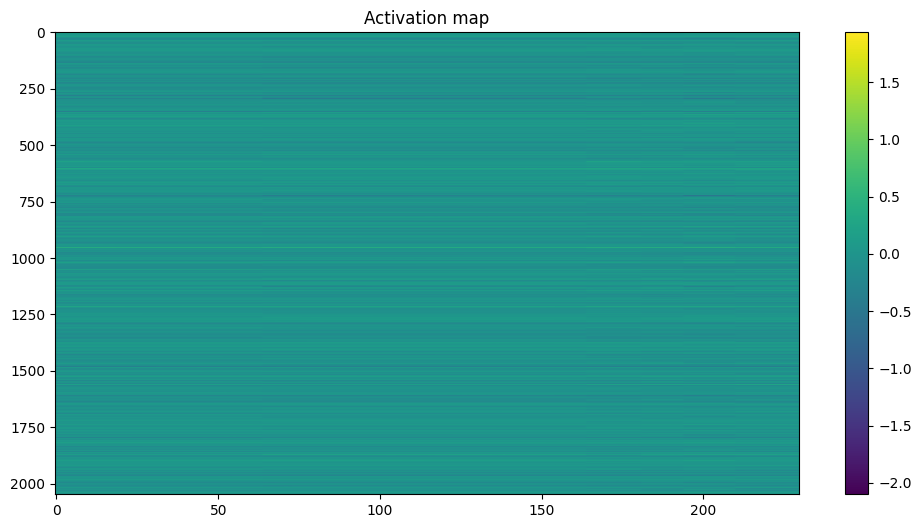

In [58]:

plt.figure(figsize=(12, 6))

plt.imshow(acts.numpy(), aspect='auto', cmap='viridis')
plt.title('Activation map')
plt.colorbar()
plt.show()

In [ ]:
run_t2i(cfg_t2i, model_t2i)

Saving images to: show-o-demo/inference_t2i_20251005_231742
Working with z of shape (1, 13, 16, 16) = 3328 dimensions.
Look-up free quantizer with codebook size: 8192


100%|██████████| 1/1 [00:35<00:00, 35.06s/it]

Saved 1 text-to-image results to show-o-demo/inference_t2i_20251005_231742
